# 5.2 - Fully non-linear problems: Seismic Receiver function search

*Written by Andrew Valentine and Malcolm Sambridge*

<!--<badge>--><a href="https://colab.research.google.com/github/msambridge/InversionPracticals/blob/main/Solutions/S5.2 - Fully nonlinear search Waveforms-solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

*Receiver functions* are a class of seismic data used to study discontinuities (layering) in the Earth's crust. At each discontinuity, P-to-S conversions occur, introducing complexity in the waveform. By deconvolving horizontal- and vertical-channel waveforms from earthquakes at teleseismic distances, we can isolate information about these conversions, and hence learn about the crustal structure. This deconvolved signal is the receiver function, and has a highly non-linear dependence on the local crustal properties.

In [5]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U pyrf96
# !git clone https://github.com/msambridge/InversionPracticals
# %cd InversionPracticals/Solutions

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pyrf96 as rf 

The function `rf.rfcalc()` computes synthetic receiver functions (using routines developed by Takuo Shibutani). It is called as follows:
```python
t,rfunc = rf.rfcalc(model)
```
where `model` is a NumPy array of dimension `[nlayers,3]`. The values in `model[:,0]` give the depths of discontinuities in the model, while `model[:,1]` contains the S-wave speed above the interface. `model[:,2]` is the ratio of S-wave speed to P-wave speed. The maximum depth of discontinuity that can be considered is 60km.

For example, here is the Earth model.

In [7]:
model = np.array([[1,4.0,1.7],
                  [3.5,4.3,1.7],
                  [8.0,4.2,2.0],
                  [20, 6,1.7],
                  [45,6.2,1.7]])

Lets calculate the receiver function.

In [8]:
# calculate and plot receiver function
t,RFp = rf.rfcalc(model)          # Noiseless Receiver function
t2,RFo = rf.rfcalc(model,sn=0.5,seed=12345678) # Receiver function with added correlated noise

Now lets plot them together.

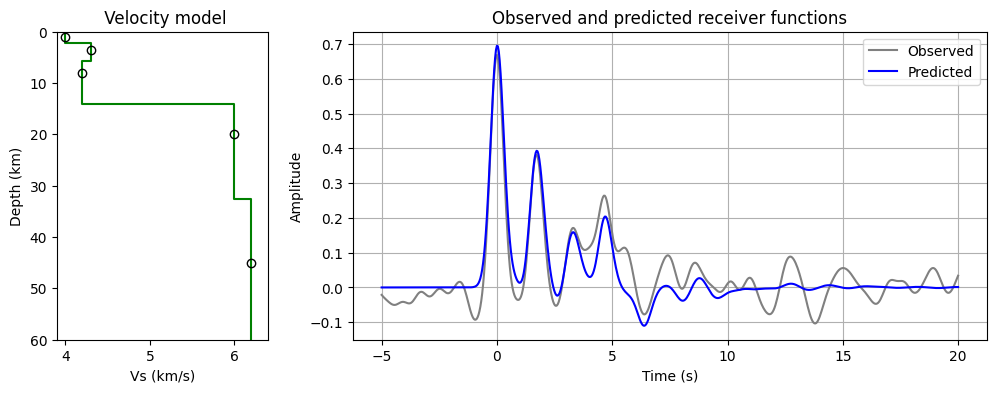

In [9]:
pv,pd = rf.plotRFm(model, t, RFo, t2, RFp, vmin=3.9,vmax=6.4)

**Task 1:** Familiarise yourself with the function `rf.rfcalc()` and explore how the receiver function behaves as you change the model.

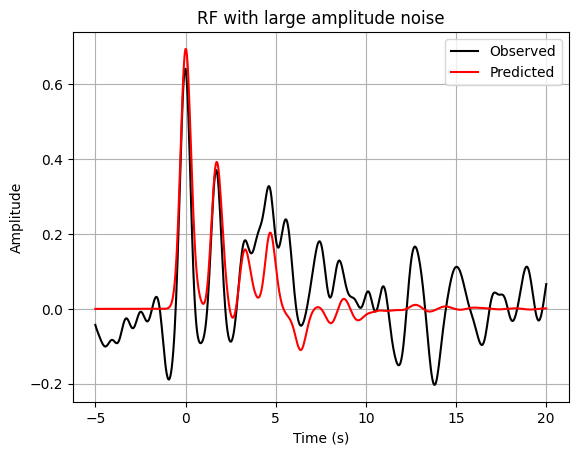

In [10]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

# calculate and plot receiver function with different parameters
t0,rfunc0 = rf.rfcalc(model)          # Receiver function
tnoise,rfunc_noise = rf.rfcalc(model,sn=1.0,seed=12345678) # Receiver function with added correlated noise

rf.plot_RFs(tnoise,rfunc_noise,t0,rfunc0,string="RF with large amplitude noise")

**Task 2:** Invent a model with around 5 layers, plot it and then compute the corresponding receiver function with the noise parameter $sn$ set to some reasonable value, say $sn=0.5$. Plot the noisy and noiseless receiver functions together just as in the figure above. We are going to treat the noisy receiver function as data.

To measure the fit of this observed receiver function to the receiver function predicted by any other model, ${\mathbf d}_{pred}$, we need to compute the negative log of the Likelihood

\begin{equation*}
-\log (p({\mathbf d}_{obs} | {\mathbf m}) = ({\mathbf d}_{obs}-{\mathbf d}_{pred})^T C_D^{-1} ({\mathbf d}_{obs}-{\mathbf d}_{pred})
\end{equation*}

where $C_D^{-1}$ is the inverse data covariance matrix describing correlated noise in the receiver function. You can do this using the supplied routine InvDataCov($\sigma_t$,$\sigma_a$,$n$), which builds an $nxn$ inverse data covariance matrix for a time signal with amplitude variance $\sigma_a^2$ and time correlation length $\sigma_t$, for receiver length of $n$ time samples. In this example you can use $\sigma_t = 2.5$, $\sigma_a=0.01$. Compute the negative log Likelihood betwen the noisy data and the predicted receiver function of the true model. 

In [11]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

Cdinv = rf.InvDataCov(2.5,0.01,len(RFo)) # This is the inverse data covaraince for the noisy receiver function

# now compute the negative log Likelihood between the receiver functions of your two models.
res = RFo-RFp
mref = np.dot(res,np.transpose(np.dot(Cdinv, res)))/2.0
print (' Waveform misfit of reference model',mref)

 Waveform misfit of reference model 1138.268046085213


**Task 3:** Now we're going to assume that we know everything about the model, except for the depth of one interface. Select one interface in your model which you will pretend is 'unknown', and plot how the agreement between 'data' and synthetics varies with this unknown. Choose ranges for each variable something like the following $(0,60 km)$ for a depth variable. Try and plot the negative log-Likelihood as a function of the depth variable. Is the minimum where you expected it to be? Does your plot give you the impression that this problem is highly nonlinear?

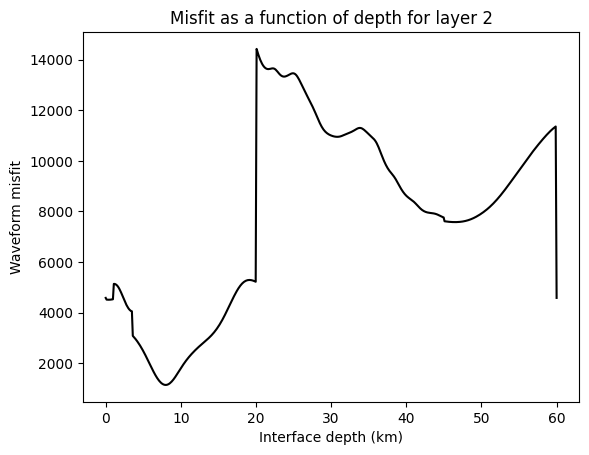

 Minimum misfit at depth  7.935871743486974  with true value at  8.0


In [12]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

# Calculate misfit as a function of depth of a chosen layer

depths = np.linspace(0.,60.,500) # depth samples
iface = 2 # index of interface
misfit = np.zeros(len(depths))
for i,d in enumerate(depths):
    m = np.copy(model)
    m[iface,0] = d
    time,RFpm = rf.rfcalc(m) # Calculate predicted noiseless Receiver function for current model
    res = RFo-RFpm
    misfit[i] = np.dot(res,np.transpose(np.dot(Cdinv, res)))/2.0
#print(misfit) 

# plot misfit profile
plt.title('Misfit as a function of depth for layer '+repr(iface))
plt.plot(depths,misfit,'k-')
plt.xlabel('Interface depth (km)')
plt.ylabel('Waveform misfit')
plt.show()
print(' Minimum misfit at depth ',depths[np.argmin(misfit)],' with true value at ',model[iface,0])


**Task 4:** Explore what happens if the unknown parameter is $V_s$ in the layer, or its $V_p/V_s$ ratio, and its depth is known. Choose ranges for each variable something like $\pm 1.0 km/s$ for a $V_s$ variable or $\pm 0.5$ for $/V_s/V_p$. 

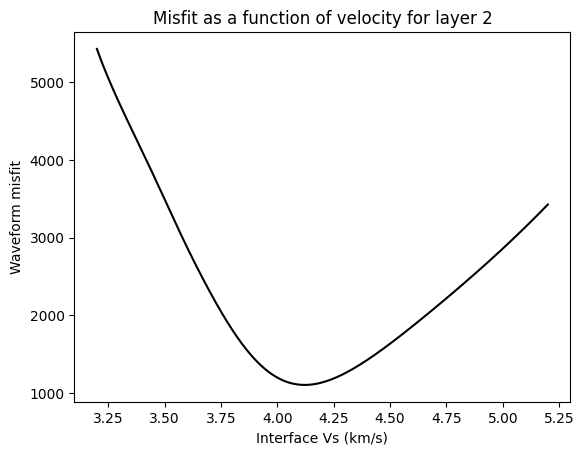

 Minimum misfit at velocity  4.121843687374749  with true value at  4.2


In [13]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

# Calculate misfit as a function of shear velocity of a chosen layer

iface = 2 # index of interface
Vs = np.linspace(model[iface,1]-1.0,model[iface,1]+1.0,500) # Vs samples
misfit = np.zeros(len(Vs))
for i,x in enumerate(Vs):
    m = np.copy(model)
    m[iface,1] = x
    time,RFpm = rf.rfcalc(m) # Calculate predicted noiseless Receiver function for current model
    res = RFo-RFpm
    misfit[i] = np.dot(res,np.transpose(np.dot(Cdinv, res)))/2.0
#print(misfit) 

# plot misfit profile
plt.title('Misfit as a function of velocity for layer '+repr(iface))
plt.plot(Vs,misfit,'k-')
plt.xlabel('Interface Vs (km/s)')
plt.ylabel('Waveform misfit')
plt.show()
print(' Minimum misfit at velocity ',Vs[np.argmin(misfit)],' with true value at ',model[iface,1])


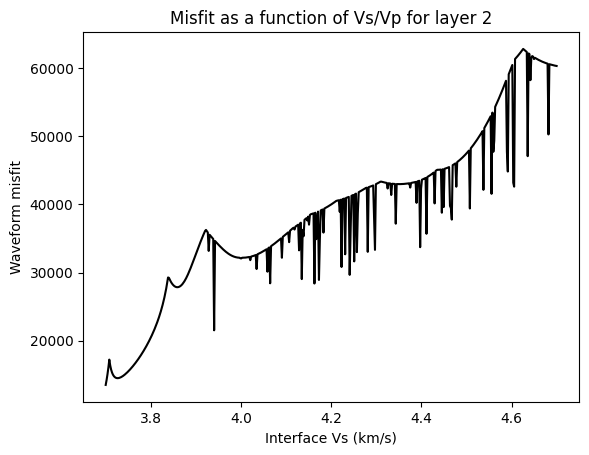

 Minimum misfit at Vs/Vp  3.7  with true value at  2.0


In [14]:

#Calculate misfit as a function of Vs/Vp ratio of a chosen layer

iface = 2 # index of interface
VsVp = np.linspace(model[iface,1]-0.5,model[iface,1]+0.5,500) # depth samples
misfit = np.zeros(len(Vs))
for i,x in enumerate(Vs):
    m = np.copy(model)
    m[iface,2] = x
    time,RFpm = rf.rfcalc(m) # Calculate predicted noiseless Receiver function for current model
    res = RFo-RFpm
    misfit[i] = np.dot(res,np.transpose(np.dot(Cdinv, res)))/2.0
#print(misfit) 

# plot misfit profile
plt.title('Misfit as a function of Vs/Vp for layer '+repr(iface))
plt.plot(VsVp,misfit,'k-')
plt.xlabel('Interface Vs (km/s)')
plt.ylabel('Waveform misfit')
plt.show()
print(' Minimum misfit at Vs/Vp ',VsVp[np.argmin(misfit)],' with true value at ',model[iface,2])


**Task 5:** Now, suppose we have two unknown parameters - the interface depth and associated $V_s$, perhaps, or two depth parameters. Map out how the agreement between 'data' and predicted receiver function varies as you change both parameters. Plot a contour map of this data misfit surface? How multi-modal is this?

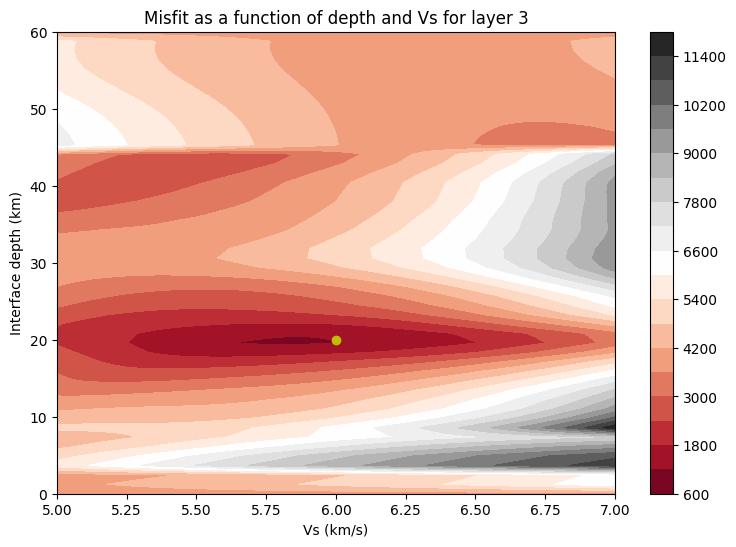

 Minimum misfit at depth  19.591836734693878  with true value at  20.0
 Minimum misfit at velocity  5.816326530612245  with true value at  6.0


In [15]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

# Calculate misfit as a function of depth of a chosen layer

iface = 3 # index of interface
depths = np.linspace(0.,60.,50) # depth samples
Vs = np.linspace(model[iface,1]-1.0,model[iface,1]+1.0,50) # Vs samples
misfit = np.zeros((len(depths),len(Vs)))
for i,d in enumerate(depths):
    for j,v in enumerate(Vs):
        m = np.copy(model)
        m[iface,0] = d
        m[iface,1] = v
        time,RFpm = rf.rfcalc(m) # Calculate predicted noiseless Receiver function for current model
        res = RFo-RFpm
        misfit[i,j] = np.dot(res,np.transpose(np.dot(Cdinv, res)))/2.0
#print(misfit) 

# plot misfit contours
fig = plt.figure(figsize=(9,6))
plt.title('Misfit as a function of depth and Vs for layer '+repr(iface))
#plt.plot(depths,misfit,'k-')
plt.ylabel('Interface depth (km)')
plt.xlabel('Vs (km/s)')
X, Y = np.meshgrid(Vs, depths)
plt.contourf(X, Y, misfit, 20, cmap='RdGy')
plt.plot(model[iface,1],model[iface,0],'yo')
plt.colorbar()
plt.show()
ix,jx = np.unravel_index(misfit.argmin(), misfit.shape) # location of misfit minimum
print(' Minimum misfit at depth ',depths[ix],' with true value at ',model[iface,0])
print(' Minimum misfit at velocity ',Vs[jx],' with true value at ',model[iface,1])


**Task 6:** Now choose to search this 2-D space with either a (nested) grid search in a square or a (nested) Gaussian sampler. In each case you must choose the density of the sampling, adjust the centre of the sampling in each iteration and record the progress toward finding the best fit solution. How close do you get to the known true values? How does the distance between the best fit solution and the true solution change with numbers of random samples? Try and plot this.

 Lowest misfit solution found after  0  iterations of Gaussian cloud  [ 5.1 30. ]
 Lowest misfit solution found after  1  iterations of Gaussian cloud  [ 5.29551756 22.43545245]
 Lowest misfit solution found after  2  iterations of Gaussian cloud  [ 5.51304417 19.38505171]
 Lowest misfit solution found after  3  iterations of Gaussian cloud  [ 5.71755649 19.68083628]
 Lowest misfit solution found after  4  iterations of Gaussian cloud  [ 5.83932215 20.2662545 ]


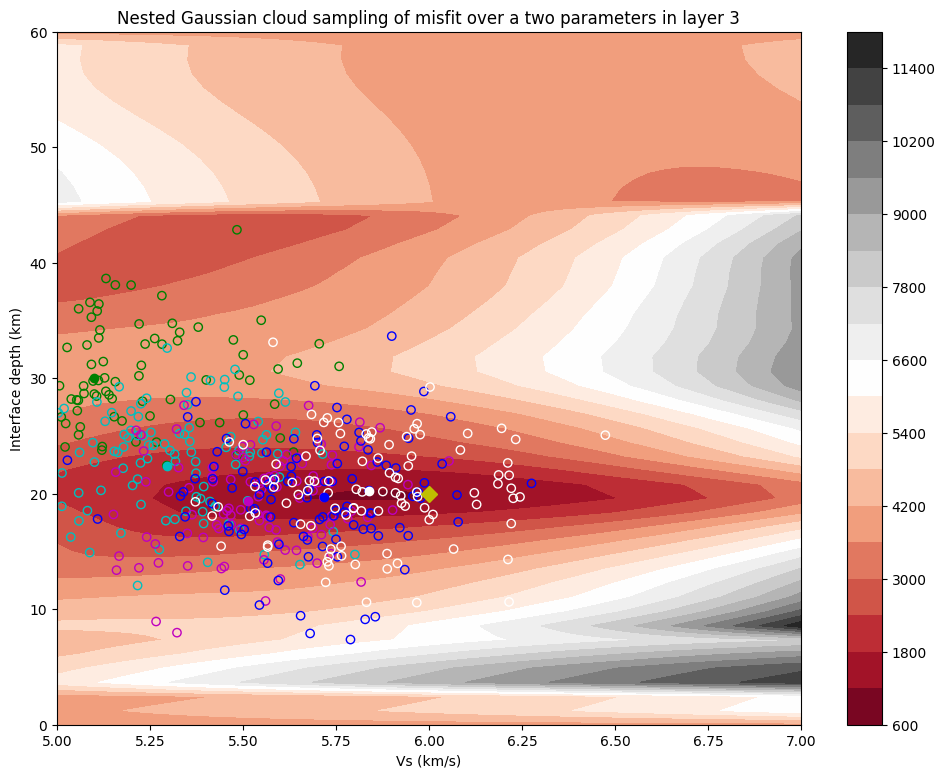

 True solution is 6.0 20.0


In [16]:
nits = 5 # number of nested iterations
nump = 100 # number of points per iteration
cov = [[0.05,0],[0,20]] # Covariance for Gaussian samples
p = np.array([])
allp = [0]*nits
bp = [0]*(nits+1)
bp[0] = np.array([5.1,30]) # starting point for Gaussian cloud matters
#bp[0] = np.array([4.5,40]) # starting point for Gaussian cloud matters
mis0 = 1e6
for it in range(nits):
    p0 = np.random.multivariate_normal(bp[it], cov,nump)
    bp[it+1] = bp[it]
    for i,x in enumerate(p0):
        if(x[1]<=depths[-1] and x[1] >= depths[0] and x[0]<=Vs[-1] and x[0] >= Vs[0]):
            p=np.append(p,[x[0],x[1]])
            m = np.copy(model)
            m[iface,0] = x[1]
            m[iface,1] = x[0]
            time,RFpm = rf.rfcalc(m) # Calculate predicted noiseless Receiver function for current model
            res = RFo-RFpm
            mis = np.dot(res,np.transpose(np.dot(Cdinv, res)))/2.0
            if(mis < mis0):
                mis0 = np.copy(mis)
                bp[it+1] = np.copy(x)
    allp[it] = np.reshape(p,(-1,2))
    p = np.array([])

fig = plt.figure(figsize=(12,9))
plt.title('Nested Gaussian cloud sampling of misfit over a two parameters in layer '+repr(iface))
#plt.plot(depths,misfit,'k-')
plt.ylabel('Interface depth (km)')
plt.xlabel('Vs (km/s)')
X, Y = np.meshgrid(Vs, depths)
plt.contourf(X, Y, misfit, 20, cmap='RdGy')
plt.plot(model[iface,1],model[iface,0],'yo')
plt.colorbar()
c = ['g','c','m','b','w']
for i in range(nits):
    plt.scatter(allp[i].T[0], allp[i].T[1], facecolors='none',edgecolors=c[i],alpha=1.0)
    plt.plot(bp[i].T[0],bp[i].T[1],'o',color=c[i])
    print(' Lowest misfit solution found after ',i,' iterations of Gaussian cloud ',bp[i])
#plt.plot(bp[i].T[0],bp[i].T[1],'wo',markersize=3.0)
plt.plot(model[iface,1],model[iface,0],'yD',markersize=8.0)
plt.scatter(bp[i].T[0],bp[i].T[1], facecolors='none',edgecolors='w',s=10.0,lw=1.0)
plt.show()
print(' True solution is',model[iface,1],model[iface,0])


**Task 7:** What happens when you repeat this process and start from a different point. Try several and see if you always get a solution? Are there starting points where it does not converge?

**Gaussian nested sampling**

This result shows the convergence of a random Gaussian cloud of 100 points initially centred on the location Vs=4.5km/s and d = 30 km. Five iterations are shown where the mean of the Gaussian samples is shifted to the best fit of the previous iteration. It gradually converges to the misfit minimum of this 2D slice. The lowest misfit found solution is the white circle and the true solution is the yellow circle.

#### A second try with a further away starting centre of the Gaussian cloud

 Lowest misfit solution found after  0  iterations of Gaussian cloud  [ 5. 40.]
 Lowest misfit solution found after  1  iterations of Gaussian cloud  [ 5.3116924  42.38307673]
 Lowest misfit solution found after  2  iterations of Gaussian cloud  [ 5.46089254 42.88501593]
 Lowest misfit solution found after  3  iterations of Gaussian cloud  [ 5.49009216 43.29614646]
 Lowest misfit solution found after  4  iterations of Gaussian cloud  [ 5.43262507 42.83467585]


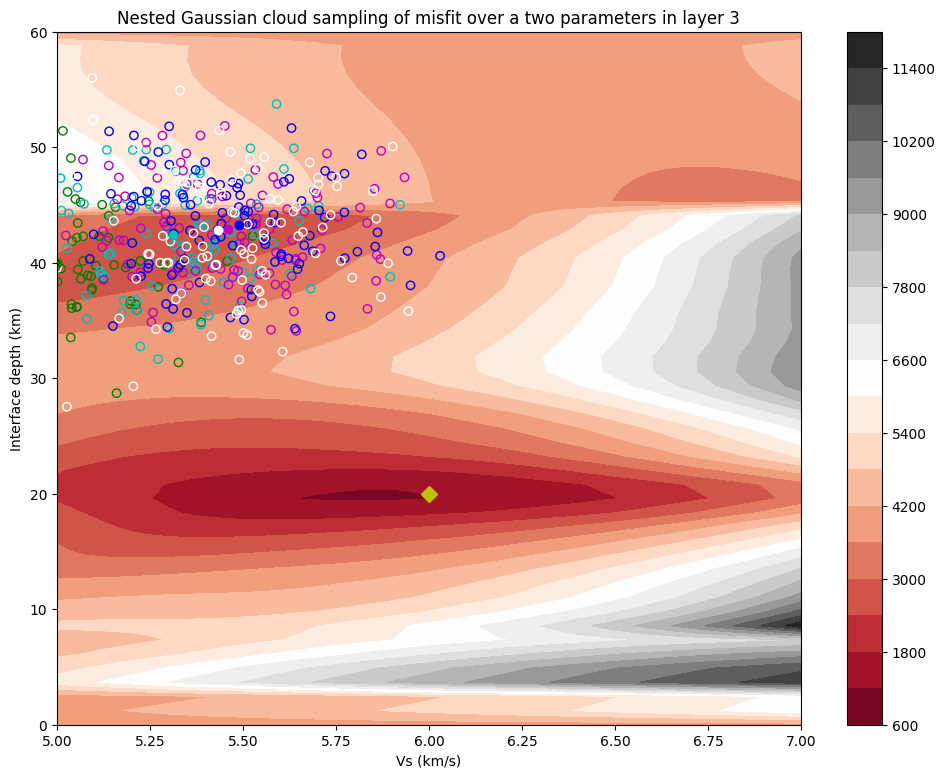

 True solution is 6.0 20.0


In [17]:
nits = 5 # number of nested iterations
nump = 100 # number of points per iteration
cov = [[0.05,0],[0,20]] # Covariance for Gaussian samples
p = np.array([])
allp = [0]*nits
bp = [0]*(nits+1)
bp[0] = np.array([5.0,40]) # starting point for Gaussian cloud matters
mis0 = 1e6
for it in range(nits):
    p0 = np.random.multivariate_normal(bp[it], cov,nump)
    bp[it+1] = bp[it]
    for i,x in enumerate(p0):
        if(x[1]<=depths[-1] and x[1] >= depths[0] and x[0]<=Vs[-1] and x[0] >= Vs[0]):
            p=np.append(p,[x[0],x[1]])
            m = np.copy(model)
            m[iface,0] = x[1]
            m[iface,1] = x[0]
            time,RFpm = rf.rfcalc(m) # Calculate predicted noiseless Receiver function for current model
            res = RFo-RFpm
            mis = np.dot(res,np.transpose(np.dot(Cdinv, res)))/2.0
            if(mis < mis0):
                mis0 = np.copy(mis)
                bp[it+1] = np.copy(x)
    allp[it] = np.reshape(p,(-1,2))
    p = np.array([])

fig = plt.figure(figsize=(12,9))
plt.title('Nested Gaussian cloud sampling of misfit over a two parameters in layer '+repr(iface))
#plt.plot(depths,misfit,'k-')
plt.ylabel('Interface depth (km)')
plt.xlabel('Vs (km/s)')
X, Y = np.meshgrid(Vs, depths)
plt.contourf(X, Y, misfit, 20, cmap='RdGy')
plt.plot(model[iface,1],model[iface,0],'yo')
plt.colorbar()
c = ['g','c','m','b','w']
for i in range(nits):
    plt.scatter(allp[i].T[0], allp[i].T[1], facecolors='none',edgecolors=c[i],alpha=1.0)
    plt.plot(bp[i].T[0],bp[i].T[1],'o',color=c[i])
    print(' Lowest misfit solution found after ',i,' iterations of Gaussian cloud ',bp[i])
#plt.plot(bp[i].T[0],bp[i].T[1],'wo',markersize=3.0)
plt.plot(model[iface,1],model[iface,0],'yD',markersize=8.0)
plt.scatter(bp[i].T[0],bp[i].T[1], facecolors='none',edgecolors='w',s=10.0,lw=1.0)
plt.show()
print(' True solution is',model[iface,1],model[iface,0])


** Gaussian nested sampling convergence to a secondary minimum**
This result shows the convergence of a random Gaussian cloud of 100 points initially centred on the location Vs=4.5km/s and d = 40 km. Five iterations are shown where the mean of the Gaussian samples is shifted to the best fit of the previous iteration. It gradually converges to a secondary minimum of this 2D slice and **not** the true global minimum. The lowest misfit found solution is the white circle and the true solution is the yellow circle.

**Task 8:** What do you think would happen if you repeat this process and increase the number of unknown parameters in your inversion? If you wish a challenge you could try it in 3 or 4 parameters, or even all of them but I suspect you will be waiting a long time for a solution!

In [18]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

print(' It gets slower and performs worse in higher dimensions!')

 It gets slower and performs worse in higher dimensions!


----